In [240]:
import seir_discrete 
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.optimize import curve_fit
import time
import tkinter as tk
from tkinter import messagebox
import math
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
def plot_one(ax, 
             predicted_days, seed_df, predicted_I, predicted_beta,
             seed_number, execution_time):
    '''
    Построение графика для seed.
    
    Параметры:

    - ax -- область для графика
    - predicted_days -- дни предсказания
    - seed_df -- DataFrame of seed, созданный регулярной сетью
    - predicted_I -- предсказанные траектория компартмента Infected
    - predicted_beta -- предсказанные значения Beta
    - seed_number -- номер seed        
    - execution_time - время предсказания Beta   
    '''
    # подсчет RMSE для значений Infected и Beta
    actual_I = seed_df.iloc[predicted_days[0]:]['I'].values 
    rmse_I = root_mean_squared_error(actual_I, predicted_I[0])
    actual_Beta = seed_df.iloc[predicted_days[0]:]['Beta'].values 
    rmse_Beta = root_mean_squared_error(actual_Beta, predicted_beta)   

    # отображение границы перехода
    ax.axvline(predicted_days[0], color='red',ls=':')

    # отображение реальных и предсказанных значений Infected
    ax.plot(seed_df.index, seed_df.iloc[:]['I'].values , color='tab:blue', label='Actual I')
    ax.plot(predicted_days, predicted_I[0],color='blue', ls='--', 
                alpha=0.9, label='Predicted I (det.)')
    
    # отображение траекторий стохастической мат. модели
    for i in range(predicted_I.shape[0]-1):
        if i==0:
            label='Predicted I (stoch.)'
        else:
            label=''
            
        ax.plot(predicted_days, predicted_I[i+1], color='tab:blue', ls='--', 
                alpha=0.3, label=label)
    
    # добавление названий осей
    ax.set_xlabel('Days')
    ax.set_ylabel('Infected', color='blue')
    ax.grid(True, alpha=0.3)
        
    ax_b = ax.twinx()
    # отображение реальных и предсказанных значений beta
    ax_b.plot(seed_df.index, seed_df['Beta'],  color='gray', ls='--', alpha=0.4, label='Actual Beta')
    ax_b.plot(predicted_days, predicted_beta,color='coral', ls='--', alpha=0.7,label='Predicted Beta ')
    
    # добавление легенды и заголовков
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_b.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    ax.set_title(f'Seed {seed_number}, \n'+
                 f'RMSE I:{rmse_I:.2f}, RMSE beta:{rmse_Beta:.2e}, \n'+
                 f'Time: {execution_time:.2e}' ,fontsize=10)
    
def load_saved_model(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    return joblib.load(model_path)

def predict_beta(I_prediction_method, seed_df, beta_prediction_method, predicted_days, 
                 stochastic, count_stoch_line, sigma, gamma):
    '''
    Предсказзание значений Beta.

    Параметры:

    - I_prediction_method -- математическая модель для предсказания траекторий Infected
        ['seir', 'sir']
    - seed_df -- DataFrame of seed, созданный регулярной сетью
    - beta_prediction_method -- метод предсказания значений Beta
        ['bi_exp_decay', 'polynom_of_day', 'percentiles']
    - predicted_days -- дни предсказания
    - stochastic -- индикатор присутствия предсказанных стохастической мат. моделью траекторий Infected 
    - count_stoch_line -- количество предсказанных стохастической мат. моделью траекторий Infected 
    - sigma -- параметр мат. модели типа SEIR
    - gamma -- параметр мат. модели типа SEIR и SIR
    '''
    predicted_I = np.zeros((count_stoch_line+1, predicted_days.shape[0]))
    execution_time = 0
    start_time = time.time()

    if beta_prediction_method == 'bi_exp_decay':
        def bi_exp_decay_func(x,a,b,c): 
            return a*(np.exp(-b*x)- np.exp(-c*x))
        given_betas = seed_df.iloc[:predicted_days[0]]['Beta'].values
        given_days = np.arange(predicted_days[0])
        coeffs, _ = curve_fit(bi_exp_decay_func, given_days, given_betas)
        predicted_beta = bi_exp_decay_func(predicted_days, *coeffs)
        predicted_beta[predicted_beta < 0] = 0
        
    elif beta_prediction_method == 'polynom_of_day':
        if I_prediction_method == 'seir':
            model_path = 'polynom_of_day_for_seir.joblib'
        else: 
            model_path = 'polynom_of_day_for_sir.joblib'
        # загрузка модели
        model = load_saved_model(model_path)
        # предсказываем значения Beta на оставшиеся дни
        log_beta = model.predict(predicted_days.reshape(-1,1))
        predicted_beta = np.exp(log_beta)

    elif beta_prediction_method == 'polynom_of_day_prev_I':
        predicted_beta = np.empty((0,))
        S = np.zeros((count_stoch_line+1, 2))
        E = np.zeros((count_stoch_line+1, 2))
        R = np.zeros((count_stoch_line+1, 2))
        # извлечение значений компартментов в день переключения на мат. модель
        S[0:count_stoch_line+1,0] = seed_df.iloc[predicted_days[0]]['S']
        predicted_I[0:count_stoch_line+1,0] = seed_df.iloc[predicted_days[0]]['I']
        R[0:count_stoch_line+1,0] = seed_df.iloc[predicted_days[0]]['R']  
        E[0:count_stoch_line+1,0] = seed_df.iloc[predicted_days[0]]['E']     
        if I_prediction_method == 'seir': 
            model_path = 'polynom_of_day_prev_I_for_seir.joblib'
        else: 
            model_path = 'polynom_of_day_prev_I_for_sir.joblib'
        
        y = np.array([S[:,0], E[:,0], predicted_I[:,0], R[:,0]])
        y = y.T
        # загрузка модели
        model = load_saved_model(model_path)
        prev_I = seed_df.iloc[predicted_days[0]-1]['I'] if predicted_days[0] > 0 else 0.0
        log_beta = model.predict([[predicted_days[0], prev_I]])
        beta = np.exp(log_beta)[0]
        predicted_beta = np.append(predicted_beta,max(beta, 0))
        for idx in range(predicted_days.shape[0]-1):
           
            # предсказание траектория компартмента Infected
            S[0,:], E[0,:], predicted_I[0,idx:idx+2], R[0,:] = predict_I(I_prediction_method, y[0], 
                                    predicted_days[idx:idx+2], 
                                    predicted_beta[idx], sigma, gamma, 'det', beta_t=False)   
            if stochastic:
                for i in range(count_stoch_line):
                    S[i+1,:], E[i+1,:], predicted_I[i+1,idx:idx+2], R[i+1,:] = predict_I(I_prediction_method, y[i+1], 
                                                predicted_days[idx:idx+2], 
                                                predicted_beta[idx], sigma, gamma, 'stoch', beta_t=False) 
           
            y = np.array([S[:,1], E[:,1], predicted_I[:,idx+1], R[:,1]])
            y = y.T
            log_beta = model.predict([[predicted_days[idx+1], predicted_I[0,idx]]])
            beta = np.exp(log_beta)[0]
            predicted_beta = np.append(predicted_beta, max(beta, 0))

    elif beta_prediction_method == 'exp_decay':
        # заглушка
        predicted_beta = [0 for i in predicted_days]    
    
    elif beta_prediction_method == 'percentiles':
        # заглушка
        predicted_beta = [0 for i in predicted_days]
    
    end_time = time.time()
    execution_time += end_time - start_time
    return predicted_beta, execution_time, predicted_I 

def predict_I(I_prediction_method, y, 
              predicted_days, 
              predicted_beta, sigma, gamma, stype, beta_t=True):
    '''
    Предсказание значений Infected.

    Параметры:

    - I_prediction_method -- математическая модель для предсказания траектории Infected
        ['seir', 'sir']
    - y -- значения компартментов в день переключения на мат. модель
    - predicted_days -- дни предсказания
    - predicted_beta -- предсказанные значения Beta
    - sigma -- параметр мат. модели типа SEIR
    - gamma -- параметр мат. модели типа SEIR и SIR
    - stype -- тип мат. модели
        ['stoch', 'det']
    '''
    
    if I_prediction_method == 'seir':
        S,E,I,R = seir_discrete.seir_model(y, predicted_days, 
                            predicted_beta, sigma, gamma, 
                            stype, beta_t).T
    else:
        if len(y) == 4:
            y = y[[0,2,3]]
        S,I,R = seir_discrete.sir_model(y, predicted_days, 
                            predicted_beta, gamma, 
                            stype, beta_t).T
        E = np.zeros((1,predicted_days.shape[0]))
    return S,E,I,R

def main_f(I_prediction_method, stochastic, count_stoch_line, beta_prediction_method, start_day, seed_numbers):
    '''
    Основная функция
    
    Параметры:
    
    - I_prediction_method -- математическая модель для построения траектории Infected
        ['seir', 'sir']
    - stochastic -- индикатор присутствия предсказанных стохастической мат. моделью траекторий Infected 
    - count_stoch_line -- количество предсказанных стохастической мат. моделью траекторий Infected 
    - beta_prediction_method -- метод предсказания значений Beta
        ['bi_exp_decay', 'polynom_of_day', 'percentiles']
    - start_day -- день переключения на мат. модель
    - seed_numbers -- номера seed для экспериментов
    
    Выход:
        График для сидов.
    '''
    # устаноавление всегда постоянных значений параметров мат. модели
    sigma = 0.1
    gamma = 0.08
    
    fig, axes = plt.subplots(len(seed_numbers)//2+math.ceil(len(seed_numbers)%2), 2, figsize=(15, 4*len(seed_numbers)//2+math.ceil(len(seed_numbers)%2)))
    axes = axes.flatten()
    
    # объявление папки с DataFrames of seeds, созданными регулярной сетью
    seed_dirs=f'{I_prediction_method}_30_seeds_v0/'

    for idx, seed_number in enumerate(seed_numbers):
        
        # чтение DataFrame of seed: S,[E],I,R,Beta
        seed_df = pd.read_csv(seed_dirs + f'{I_prediction_method}_seed_{seed_number}.csv')
        seed_df = seed_df[pd.notna(seed_df['Beta'])]

        # выбор дней для предсказания
        predicted_days = np.arange(start_day, seed_df.shape[0])
        
        # предсказание значений Beta и подсчет времени этого процесса
        predicted_beta, execution_time, predicted_I = predict_beta(I_prediction_method, seed_df, beta_prediction_method, predicted_days, stochastic, count_stoch_line, sigma, gamma)

        if beta_prediction_method != 'polynom_of_day_prev_I':
            # извлечение значений компартментов в день переключения на мат. модель
            y = seed_df.iloc[predicted_days[0]].drop('Beta')

            # предсказание траектория компартмента Infected
            _,_,predicted_I[0],_ = predict_I(I_prediction_method, y, 
                                    predicted_days, 
                                    predicted_beta, sigma, gamma, 'det')
            if stochastic:
                for i in range(count_stoch_line):
                    _,_,predicted_I[i+1],_ = predict_I(I_prediction_method, y, 
                                                predicted_days, 
                                                predicted_beta, sigma, gamma, 'stoch')

        # построение графика для seed_number
        ax = axes[idx]
        plot_one(ax, predicted_days, seed_df, predicted_I, predicted_beta, seed_number, execution_time)        
    
    
    # добавление общего заголовка
    fig.suptitle(f'Switch {start_day} day, \n'+
                 f'I_prediction_method:{I_prediction_method}, \n'+
                 f'beta_prediction_method: {beta_prediction_method}' ,fontsize=15)
    plt.tight_layout()
    plt.show()   

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


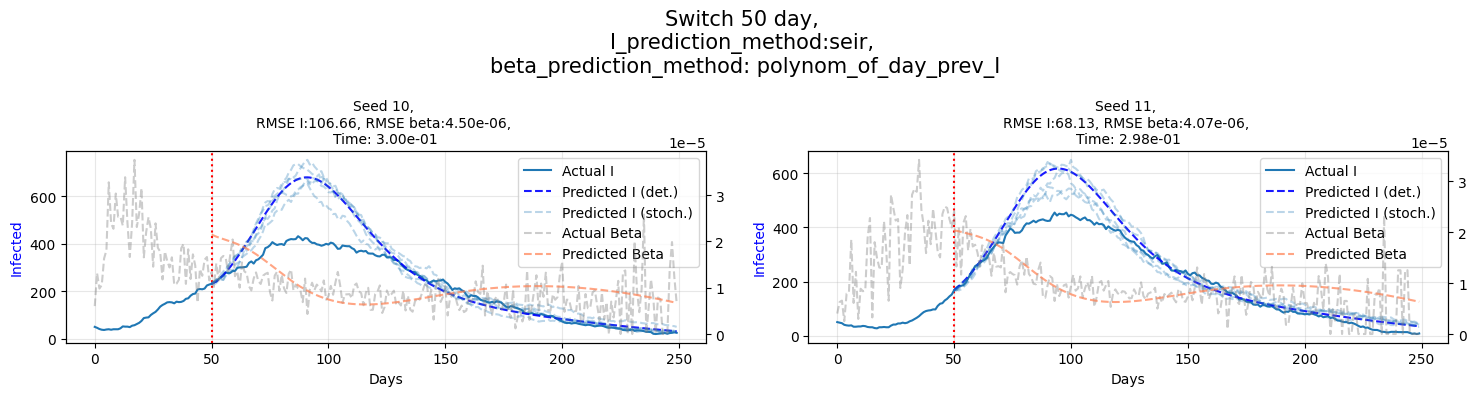

In [242]:
'''
Создание графического окна для ввода параметров
'''
def parse_seeds(seeds_input):
    ''' 
    Сортировка numbers of seeds
    '''

    # использование множества уникальных значений
    seeds = set()  
   
    parts = seeds_input.split(',') 
    for part in parts:
        if '-' in part:  # определение диапазона по тире
            start, end = part.split('-')
            seeds.update(range(int(start), int(end)))  # добавление чисел из диапазона
        else:
            seeds.add(int(part))  # добавление отдельных номеров seed
            
    return sorted(seeds)

def calculate():
    try:
        # получение значениий из полей ввода
        I_prediction_method = var_I_prediction_method.get()
        stochastic = var_stochastic.get()
        count_stoch_line = int(entry_count_stoch_line.get()) if stochastic else 0  # получение количества случайных траекторий, если включена стохастичность
        beta_prediction_method = var_beta_prediction_method.get()
        start_day = int(entry_start_day.get())
        seed_numbers = entry_seed_numbers.get()

        # сортировка numbers of seeds
        seed_numbers = parse_seeds(seed_numbers)
        
        # вызов основной функции
        result = main_f(I_prediction_method, stochastic, count_stoch_line, beta_prediction_method, start_day, seed_numbers)
        
        # вывод результата
        messagebox.showinfo("Результат", result)
    except ValueError:
        messagebox.showerror("Ошибка", "Пожалуйста, введите корректные данные.")
    except Exception as e:
        messagebox.showerror("Ошибка", f"Произошла ошибка: {str(e)}")

# создание главного окна
root = tk.Tk()
root.title("Ввод параметров")

# создание переменной для выбора мат. модели
var_I_prediction_method = tk.StringVar(value="seir")  # установка значения по умолчанию
# создание выпадающего списока для выбора мат. модели
label_I_prediction_method = tk.Label(root, text="Метод предсказания Infected:")
label_I_prediction_method.pack()
I_prediction_method_options = ["seir", "sir"]
dropdown_I_prediction_method = tk.OptionMenu(root, var_I_prediction_method, *I_prediction_method_options)
dropdown_I_prediction_method.pack()

# создание флажка для стохастичности
var_stochastic = tk.BooleanVar(value=False)
checkbox_stochastic = tk.Checkbutton(root, text="Стохастичность", variable=var_stochastic, command=lambda: toggle_stochastic_entry())
checkbox_stochastic.pack()

# создание метки и поля ввода для количество стохастических траекторий
label_count_stoch_line = tk.Label(root, text="Количество случайных траекторий:")
label_count_stoch_line.pack()
entry_count_stoch_line = tk.Entry(root)
entry_count_stoch_line.pack()
entry_count_stoch_line.config(state='disabled')  # изначальное отключение поле ввода
# функция для включения/выключения поля ввода в зависимости от состояния флажка
def toggle_stochastic_entry():
    if var_stochastic.get():
        entry_count_stoch_line.config(state='normal')  # включение поля ввода
    else:
        entry_count_stoch_line.config(state='disabled')  # отключение поля ввода

# создание переменной для выбора метода предсказания значений Beta
var_beta_prediction_method = tk.StringVar(value="polynom_of_day")  # Устанавливаем значение по умолчанию
# создание выпадающего список для выбора метода
label_beta_prediction_method = tk.Label(root, text="Метод предсказания Beta:")
label_beta_prediction_method.pack()
beta_prediction_method_options = ['polynom_of_day', 'bi_exp_decay', 'polynom_of_day_prev_I','percentiles']
dropdown_beta_prediction_method = tk.OptionMenu(root, var_beta_prediction_method, *beta_prediction_method_options)
dropdown_beta_prediction_method.pack()

# создание метки и поля ввода деня переключения на мат. модель
label_start_day = tk.Label(root, text="День начала:")
label_start_day.pack()
entry_start_day = tk.Entry(root)
entry_start_day.pack()

# создание метки и поля ввода для numbers of seeds
label_seed_numbers = tk.Label(root, text="Seed_numbers (через запятую или диапазон через тире):")
label_seed_numbers.pack()
entry_seed_numbers = tk.Entry(root)
entry_seed_numbers.pack()

# создание кнопки для выполнения вычисления
button_calculate = tk.Button(root, text="Вычислить", command=calculate)
button_calculate.pack()

# запуск главного цикла приложения
root.mainloop()